In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)

def reduce_xticks(p, n: int):
    # FIXME reducing the number of xticks
    # from https://stackoverflow.com/a/38947307/14403987
    for i, label in enumerate(p.get_xticklabels()):
        label.set_visible(True if i % 12 == 0 else False)

DATA_PATH = Path("..", "..", "data")
SALES_PATH = DATA_PATH / "tbl_vendas_mensais.csv"

raw_data = pd.read_csv(SALES_PATH, sep = ";", decimal=",")

TARGET, SKU_COL, SKU_NAME = "qt_sale", "id_sku", "ds_sku"

# since `dt_sale` is only related to the month, we can drop the rest
raw_data["dt_sale"] = pd.to_datetime(raw_data.dt_sale)

# `MachinaMetal` had two instances of 2021-11, therefore they should be grouped
numeric_columns = raw_data.columns[raw_data.dtypes.isin([np.dtype("int64"), np.dtype("float64")])].difference([SKU_COL])
# data = raw_data.groupby(by = raw_data.columns.difference(numeric_columns).to_list()).aggregate(np.sum).reset_index()
data = raw_data.groupby(by = raw_data.columns.difference(numeric_columns).to_list()).aggregate(np.mean).reset_index()
data[SKU_COL] = data[SKU_COL].astype(str)

# # from `src/analysis/notebook.ipynb`

# def fix_sales(name: str, previous: float, current: float, rate: float = 1.5, top_rate: float = 50.):
#     """Compares `previous` and `current`, returning `rate * previous` if `current / previous > 1.5`.
#     Receives `name` for debugging purposes."""
#     # print(name, previous, current, current / previous, sep = "\t")
#     if rate < current / previous < top_rate:
#         return rate * previous
#     # keep the original value, as `Nyc Urban` had one sold item in 2020-11, but 960 in 2021-11
#     return current

# # seems to be due to end of the year sales (it is frequently in October, November or December),
# # but 2021-11 is seems to be a very hard outlier 5_540_951 / 2_986_284 = 1.85
# # therefore it will be normalized to be at most 1.5 times the average sales
# # of the previous November per product

# previous_sales = data[data.dt_sale == "2020-11"].groupby(SKU_COL).aggregate("qt_sale").sum().to_dict()

# data.loc[data.dt_sale == "2021-11", "qt_sale"] = \
#     data.loc[data.dt_sale == "2021-11", [SKU_COL, SKU_NAME, "qt_sale"]].apply(
#         lambda row: fix_sales(f"{row[SKU_COL]}-{row[SKU_NAME]}", previous_sales.get(row[SKU_COL], 1.), row["qt_sale"], 1.5), axis = 1
#     )



In [2]:
data

,ds_brand_segment,ds_category,ds_product_line,ds_sku,ds_tecnology,dt_sale,id_sku,qt_sale,vl_sale_price
0,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-01-01,10,3742.0,200646.5232
1,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-02-01,10,4156.0,222872.3922
2,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-03-01,10,3748.0,200976.1040
3,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-04-01,10,3398.0,182246.8222
4,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-05-01,10,3628.0,194581.4786
...,...,...,...,...,...,...,...,...,...
1830,Target,Infinity Boot,Boot,Zeus,LiteWeave,2022-11-01,14,29751.0,775617.5464
1831,Target,Infinity Boot,Boot,Zeus,LiteWeave,2022-12-01,14,27258.0,710617.0391
1832,Target,Infinity Boot,Boot,Zeus,LiteWeave,2023-01-01,14,22752.0,593160.3267
1833,Target,Infinity Boot,Boot,Zeus,LiteWeave,2023-02-01,14,21444.0,559049.0585


<AxesSubplot: xlabel='dt_sale', ylabel='qt_sale'>

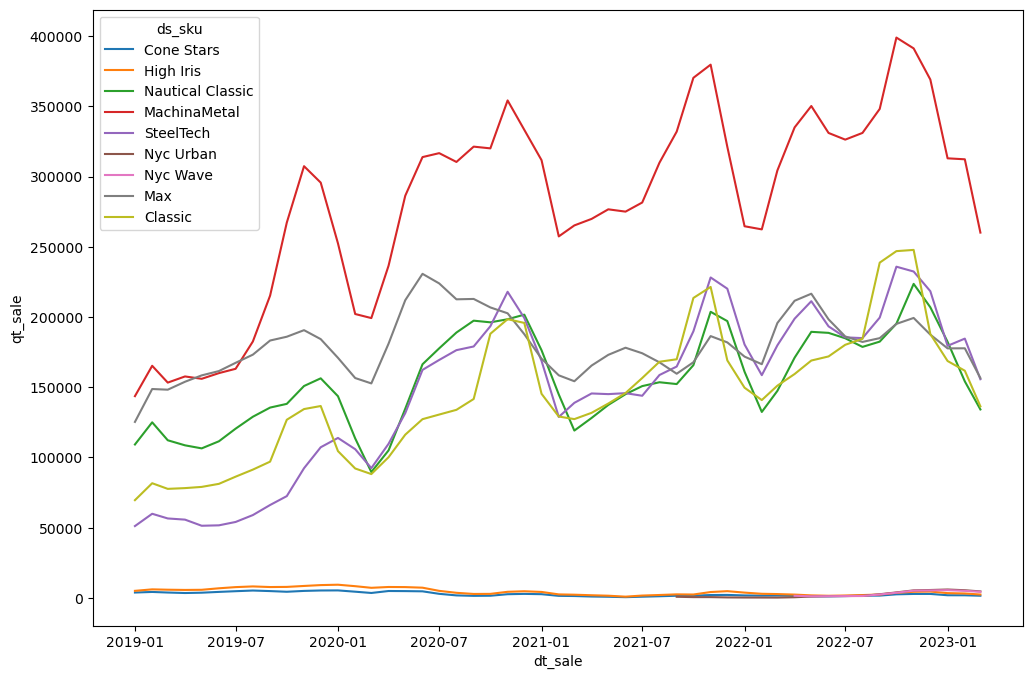

In [3]:
gdata = data.groupby(by = [SKU_COL, SKU_NAME]).agg(TARGET).sum().sort_values(ascending = False).reset_index()

n = 5
top_bottom = gdata.iloc[[*range(n), *range(-n, -1)]]

sns.lineplot(x = "dt_sale", y = TARGET, hue = SKU_NAME, data = data[data[SKU_COL].isin(top_bottom[SKU_COL])])

In [4]:
# data["dt_sale"] = data.dt_sale.dt.to_period("M")

### Which features should be included?

In [5]:
# check if there is different `ds_category` for the same `ds_sku`	
data.groupby("ds_sku").agg({"id_sku": lambda x: len(np.unique(x))}).sort_values(by = "id_sku", ascending = False).head(3)

# only `Hawaii` has two different `ds_tecnology`

# both `Hawaii` and `TitaniumTech` are part of different `ds_product_line`, which does
# ~~most probably~~ correlates to being different products (different `id_sku`);
# therefore, forecasts should be made over `id_sku` and not `ds_sku`

# therefore, only the timeseries will be used as feature

,id_sku
ds_sku,
TitaniumTech,2
Hawaii,2
AeroJet,1


## For each `ds_sku`, forecast the next 3 months

In [6]:
expected_groups = (
    (1, 2, 3),
    (4, 5, 6),
    (7, 8, 9, 10),
    (11, 12, 13, 14, 15),
    (16, 17, 19, 20, 21, 35),
    (22, *range(24, 30)),
    (23,),
    (31, 32, 33),
    (34, 36, 37),
    (39,),
)

ax_map = {j: i for i, g in enumerate(expected_groups) for j in g}

In [7]:
# pd.Series(
#     index = pd.to_datetime(data["dt_sale"]).asfreq("MS"),
#     data = data["qt_sale"]
# )

this = data["dt_sale"].asfreq("MS")
this
# pd.to_datetime(data["dt_sale"], freq = "MS")

1970-01-01   NaT
Freq: MS, Name: dt_sale, dtype: datetime64[ns]

In [8]:
# should all products be forecasted or only the ones that were present in the last month?

# for simplicity sake, only the products that were present in the last month will be forecasted
# moreover, only the top 10 products in terms of sales will be forecasted 

# furthermore, only the products that are affected by seasonality (check ACF) and have a high volume
# of sales will be considered

In [9]:
id2name = data.groupby(by = SKU_COL).agg({SKU_NAME: "first"})[SKU_NAME].to_dict()
fdata = data[[SKU_COL, SKU_NAME, "dt_sale", "qt_sale"]].copy()

In [10]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LaggedTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, lags=[], seasonal_lags=[]):
        self.column = column
        self.lags = lags
        self.seasonal_lags = seasonal_lags

    def fit(self, X):
        return self

    def transform(self, X):
        X_lagged = X.copy()
        for lag in self.lags:
            X_lagged[f"{self.column}_{lag}"] = X_lagged[self.column].shift(lag)
        for lag in self.seasonal_lags:
            X_lagged[f"{self.column}_seasonal_lag_{lag}"] = X_lagged[self.column].shift(lag)
        return X_lagged.dropna()

class CurrentMonthYearFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, date_column: str) -> None:
        super().__init__()
        self.date_column = date_column

    def fit(self, X):
        return self

    def transform(self, X):
        X_month_year = X.copy()
        X_month_year["month"] = X_month_year[self.date_column].dt.month
        X_month_year["year"] = X_month_year[self.date_column].dt.year
        return X_month_year # .drop([self.date_column], axis=1)
    
class MovingAverage(BaseEstimator, TransformerMixin):

    def __init__(self, target: str, q: int) -> None:
        super().__init__()
        self.target = target
        self.q = q

    def fit(self, X):
        return self
    
    def transform(self, X):
        X_averaged = X.copy()
        X_averaged[f"{self.target}_ma_{self.q}"] = X_averaged[self.target].rolling(self.q).mean()
        return X_averaged.dropna()

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # FIXME
from sklearn.linear_model import LinearRegression

def preprocessing(data, target_column: str, transform_pipeline):
    pdata = transform_pipeline.fit_transform(data)
    X, y = pdata.drop(columns = [target_column]), pdata[target_column]
    return X, y

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class Naive(BaseEstimator):

    def __init__(self, columns: str) -> None:
        super().__init__()
        self.columns = columns

    def fit(self, X, y):
        return self

    def predict(self, X):
        return X[self.columns].mean(axis=1)

In [55]:
test_size, random_state = .25, 42

naive_model = lambda X: np.mean(X, axis = 1)

# fig, axs = plt.subplots(fdata[SKU_COL].nunique() // 2 + 1, 2, figsize = (6, 16))
# axs = axs.flatten()

estimators = {}
for i, (name, group) in enumerate(fdata.groupby(by = [SKU_COL, SKU_NAME])):

    id_, name_ = name
    estimators.setdefault(id_, {})

    fig = plt.figure(figsize = (6, 4))
    ax = fig.add_subplot(1, 1, 1)

    for c, transform, model in (
        (
            "blue", 
            make_pipeline(
                LaggedTimeFeatures("qt_sale", lags=[1], seasonal_lags=[12]),
                CurrentMonthYearFeatures("dt_sale"),
            ), 
            Naive(["qt_sale_1", "qt_sale_seasonal_lag_12"])
        ),
        (
            "red",
            MovingAverage("qt_sale", 3),
            Naive(["qt_sale_ma_3"])
        )
    ):

        if group.shape[0] < 13:
            print(f"Skipped {i}, not enough data")
            continue

        # if (axidx := ax_map.get(int(id_), False)) is False:
        #     print(f"Skipped `{id_}`, not found in {ax_map}")
        #     continue

        # ax = axs[axidx // 2, axidx % 2]
        # ax = axs[i]

        # TODO select model based on `expected_groups`

        # feature engineering and train/test split
        X, y = preprocessing(group.drop(columns = [SKU_COL, SKU_NAME]), TARGET, transform)
        # print(id_, X.shape, y.shape, gdata.shape)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, shuffle = False
        )
        xaxis = group.dt_sale.iloc[-(X_train.shape[0] + X_test.shape[0]):]

        # Show time series
        xaxis_train, xaxis_test = xaxis.iloc[:X_train.shape[0]], xaxis.iloc[X_train.shape[0]:]
        sns.lineplot(x = xaxis_train, y = y_train, alpha = .8, ax = ax)
        sns.lineplot(x = xaxis_test, y = y_test, alpha = 1., c = "orange", linestyle = "--", ax = ax)

        # FIXME should go through a pipeline
        # FIXME features should be selected automatically
        model.fit(X_train.drop(columns = ["dt_sale"]), y_train)
        yhat = model.predict(X_test.drop(columns = ["dt_sale"]))

        # model_name = model.__class__.__name__
        estimators[id_].setdefault(c, (abs(y_test - yhat)).sum())

        sns.lineplot(x = xaxis_test, y = yhat, alpha = .6, c = c, ax = ax)#, label = f"[{id_}]{model_name}")
        plt.title(f"[{id_}]{name_}")

    reduce_xticks(ax, 6)
    fig.savefig(f"../imgs/{id_}_{name_}.png")
    plt.close()

Skipped 25, not enough data
Skipped 25, not enough data
Skipped 26, not enough data
Skipped 26, not enough data


In [54]:
results = pd.DataFrame(estimators).T
(results["lightblue"] < results["red"]).sum() / data[SKU_COL].nunique()

0.717948717948718

In [ ]:
# from datetime import timedelta
# from statsmodels.tsa.statespace.sarimax import SARIMAX # FIXME how to use it into a sklearn pipeline?

# import warnings
# from statsmodels.tools.sm_exceptions import ValueWarning

# def sarima(data, date: str, target: str, **sarimax_kwargs):

#     d = data.copy()
#     d[date].asfreq("MS")
#     endog = d.set_index(date)[target]

#     X_train, X_test = endog.iloc[:-12], endog.iloc[-12:]
#     with warnings.catch_warnings():
#         # warnings.simplefilter(ValueWarning)
#         model = SARIMAX(X_train, **sarimax_kwargs).fit()
#     yhat = model.predict(start = X_test.index[0] - timedelta(days = 1), end = X_test.index[-1])
#     return X_train, X_test, yhat

# def ts_plot(X_train, X_test, yhat, ax):
#     sns.lineplot(x = X_train.index, y = X_train, ax = ax)
#     sns.lineplot(x = X_test.index, y = X_test, ax = ax, linestyle = "--")
#     sns.lineplot(x = [X_train.index[-1], X_test.index[0]], y = [X_train.iloc[-1], X_test.iloc[0]], ax = ax, linestyle = "--")
#     sns.lineplot(x = yhat.index, y = yhat, ax = ax, c = "red", alpha = .8)
#     return ax

# group_params = {
#     0: dict(
#         order = (1, 0, 0),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     1: dict(
#         order = (1, 0, 1),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     # FIXME how to preselect data? structural change
#     2: dict(
#         order = (1, 0, 1),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     # FIXME how to preselect data? structural change
#     3: dict(
#         order = (0, 0, 0),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     4: dict(
#         order = (1, 0, 1),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     5: dict(
#         order = (1, 0, 1),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     # FIXME how to preselect data? structural change
#     6: dict(
#         order = (0, 0, 0),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     7: dict(
#         order = (0, 0, 3), # benchmark
#     ),
#     8: dict(
#         order = (1, 0, 1),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
#     9: dict(
#         order = (0, 0, 0),
#         seasonal_order = (1, 0, 0, 12), 
#     ),
# }

# fig, axs = plt.subplots(5, 2, figsize = (20, 20))
# for ((id_, name_), gdata) in data.groupby(by = [SKU_COL, SKU_NAME]):

#     if (i := ax_map.get(int(id_), False)) is False:
#         print(f"Skipped {id_}, not found")
#         continue

#     if gdata.shape[0] < 12 * 2 + 1:
#         print(f"Skipped {i}, not enough data")
#         break

#     ax = axs[i // 2, i % 2]
#     print(f"Plotting {id_}")

#     X_train, X_test, yhat = sarima(
#         gdata, 
#         **group_params[i],
#         date = "dt_sale", 
#         target = "qt_sale"
#     )
#     ts_plot(X_train, X_test, yhat, ax)

#     reduce_xticks(ax, 12)

# plt.show()